In [132]:
!pip install -U -q google-generativeai

In [133]:
import re
import tqdm
import numpy as np
import pandas as pd
import google.generativeai as GenAi
import keras
import google.ai.generativelanguage as glm
from google.colab import userdata

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras import layers
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skmetrics

In [134]:
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
GenAi.configure(api_key=GOOGLE_API_KEY)

# Dataset
The 20 Newsgroups Text Dataset{:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the subsets of the training and test datasets. You will preprocess and organize the data into Pandas dataframes.

In [135]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [136]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [137]:
idx = newsgroups_train.data[1].index('Lines')
print(newsgroups_train.data[1][idx:])

Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



Now you will begin preprocessing the data for this tutorial. Remove any sensitive information like names, email, or redundant parts of the text like ```"From: "``` and ```"\nSubject: "```. Organize the information into a Pandas dataframe so it is more readable.

In [138]:
def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

In [139]:
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [140]:
def sample_data(df, num_samples, classes_to_keep):
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)

  df = df[df['Class Name'].str.contains(classes_to_keep)]

  # Reset the encoding of the labels after sampling and dropping certain categories
  df['Class Name'] = df['Class Name'].astype('category')
  df['Encoded Label'] = df['Class Name'].cat.codes

  return df


In [141]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci' # Class name should contain 'sci' in it to keep science categories
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

<ipython-input-140-4e962cbdf09d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
<ipython-input-140-4e962cbdf09d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)


In [142]:
df_train.value_counts('Class Name')

,count
Class Name,
sci.crypt,100
sci.electronics,100
sci.med,100
sci.space,100


In [143]:

df_test.value_counts('Class Name')

,count
Class Name,
sci.crypt,25
sci.electronics,25
sci.med,25
sci.space,25


## Create the embeddings

In this section, you will see how to generate embeddings for a piece of text using the embeddings from the Gemini API. To learn more about embeddings, visit the [embeddings guide](https://ai.google.dev/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, large sample sizes can take a long time!

### API changes to Embeddings embedding-001

For the new embeddings model, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [144]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLASSIFICATION.
    embedding = GenAi.embed_content(model=model,
                                    content=text,
                                    task_type="classification")
    return embedding['embedding']

  return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

In [145]:
model = 'models/embedding-001'
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [146]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,List of large integer arithmetic packages\nOr...,11,sci.crypt,0,"[0.01540486, -0.021492952, -0.09030825, -0.029..."
1101,(Stephan Neuhaus )Re: Do we need the clipper ...,11,sci.crypt,0,"[-0.004582743, -0.053288747, -0.064975366, -0...."
1102,Re: Secret algorithm [Re: Clipper Chip and cr...,11,sci.crypt,0,"[0.01293473, -0.011347624, -0.099487066, -0.02..."
1103,Re: White House Public Encryption Management ...,11,sci.crypt,0,"[0.02265497, -0.02592585, -0.054873865, -0.073..."
1104,Re: text of White House announcement and Q&As...,11,sci.crypt,0,"[-0.0062948405, -0.016994176, -0.05160227, -0...."


## Build a simple classification model
Here you will define a simple model with one hidden layer and a single class probability output. The prediction will correspond to the probability of a piece of text being a particular class of news. When you build your model, Keras will automatically shuffle the data points.

In [147]:
# Function to build the classification model
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
    inputs = x = keras.Input(shape=(input_size,))
    x = layers.Dense(input_size, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)  # Use softmax for multi-class classification
    return keras.Model(inputs=inputs, outputs=x)

# Derive the embedding size and number of classes
embedding_size = len(df_train['Embeddings'].iloc[0])
num_classes = len(df_train['Class Name'].unique())

# Create the classifier model
classifier = build_classification_model(embedding_size, num_classes)
classifier.summary()

# Compile the model with appropriate loss and optimizer
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 768)                 │         590,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           3,076 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [148]:
embedding_size

768

## Train the model to classify newsgroups

Finally, you can train a simple model. Use a small number of epochs to avoid overfitting. The first epoch takes much longer than the rest, because the embeddings need to be computed only once.

In [149]:
NUM_EPOCHS = 10
BATCH_SIZE = 20

# Split the x and y components of the train and validation subsets.
y_train = df_train['Encoded Label']
x_train = np.stack(df_train['Embeddings'])
y_val = df_test['Encoded Label']
x_val = np.stack(df_test['Embeddings'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4275 - loss: 1.2368 - val_accuracy: 0.7800 - val_loss: 0.8312
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9376 - loss: 0.6100 - val_accuracy: 0.9400 - val_loss: 0.4110
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9719 - loss: 0.2664 - val_accuracy: 0.9500 - val_loss: 0.2480
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9781 - loss: 0.1478 - val_accuracy: 0.9700 - val_loss: 0.1829
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9831 - loss: 0.0990 - val_accuracy: 0.9600 - val_loss: 0.1644
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9920 - loss: 0.0664 - val_accuracy: 0.9600 - val_loss: 0.1318
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9994 - loss: 0.0398 - val_accuracy: 0.9600 - val_loss: 0.1209
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0322 - val_accuracy: 0.9600 - v

## Evaluate model performance

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate"><code>Model.evaluate</code></a> to get the loss and accuracy on the test dataset.

In [150]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9559 - loss: 0.0994  


{'accuracy': 0.9599999785423279, 'loss': 0.09801054000854492}

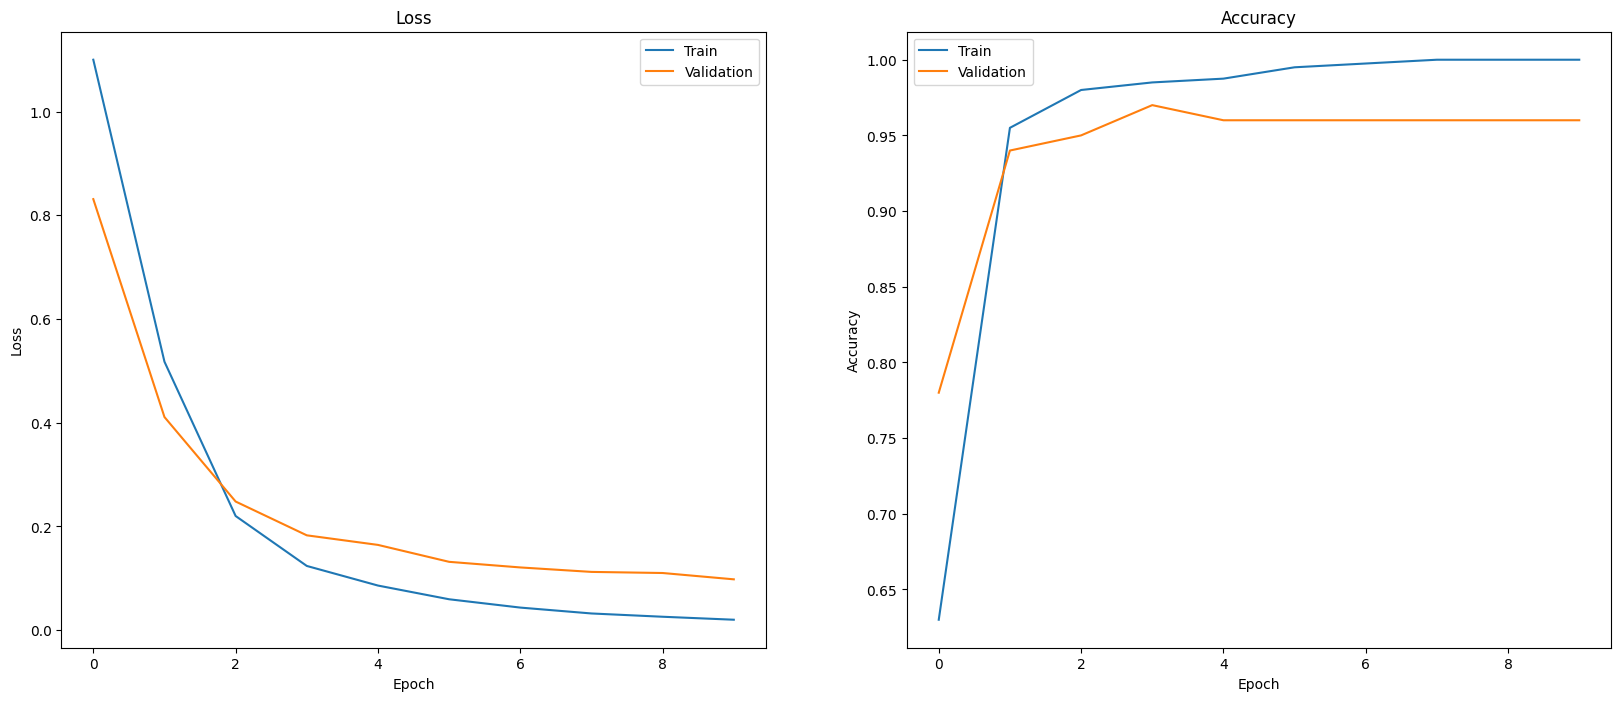

In [151]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

Another way to view model performance, beyond just measuring loss and accuracy is to use a confusion matrix. The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

Start by generating the predicted class for each example in the validation set using [`Model.predict()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

In [152]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [153]:
labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label']))
labels_dict

{'sci.crypt': 0, 'sci.electronics': 1, 'sci.med': 2, 'sci.space': 3}

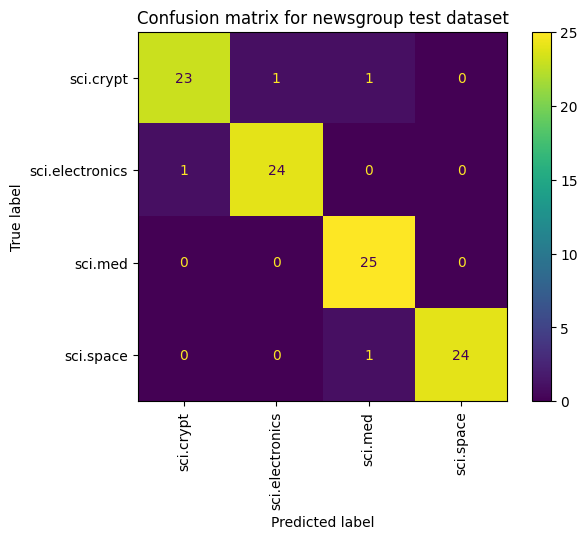

In [154]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)